## Example 2.22 Using Projection to Recommend Recipe Ingredient Pairings

This example solves a recommendation problem that links similar ingredients 
together based on recipe data. By using the PROJECTION statement, you can
find pairs of ingredients that occur together in one or more recipes.

To learn more, visit the [projection documentation](https://go.documentation.sas.com/?cdcId=pgmsascdc&cdcVersion=default&docsetId=casmlnetwork&docsetTarget=casmlnetwork_network_syntax22.htm&locale=en).

In [1]:
import pandas as pd
import swat
import sys
sys.path.append(r"../../../common/python")
import visualization as vz
import cas_connection as cas

In [2]:
swat.options.cas.print_messages=False
s = cas.reconnect()
s.loadActionSet('network')

[actionset]

 'network'

+ Elapsed: 0.00744s, user: 0.00364s, sys: 0.00375s, mem: 0.252mb

### Define the Input Graph
In the following links data, the inclusion of ingredients in recipes
is organized into a bipartite network.

We treat the input data, a list of ingredients in each recipe, as an adjacency list.

In [3]:
adj_list = {
         'Spag Sauce': ['Tomato', 'Garlic', 'Salt', 'Onion', 'TomatoPaste', 'OliveOil',
                        'Oregano', 'Parsley'],
    'Spag Meat Sauce': ['Tomato', 'Garlic', 'Salt', 'Onion', 'TomatoPaste', 'OliveOil',
                        'Celery', 'GreenPepper', 'BayLeaf', 'GroundBeef', 'Carrot',
                        'PorkSausage', 'RedPepper'],
    'Eggplant Relish': ['Garlic', 'Salt', 'Onion', 'TomatoPaste', 'OliveOil', 'Eggplant',
                        'GreenOlives', 'Capers', 'Sugar'],
       'Creole Sauce': ['Tomato', 'Salt', 'Onion', 'TomatoPaste', 'OliveOil', 'Celery',
                        'Broth', 'GreenPepper', 'BlackPepper', 'Paprika', 'Thyme',
                        'WorcestershireSauce'],
              'Salsa': ['Tomato', 'Garlic', 'Salt', 'Onion', 'Cilantro', 'Tomatillo',
                        'JalapenoPepper', 'Lime'],
    'Enchilada Sauce': ['Tomato', 'Broth', 'Cumin', 'Flour', 'BrownSugar', 'ChiliPowder',
                        'CayennePepper', 'Oil']
}

The following statements convert the adjacency list into a list of links in DataFrame format.

In [4]:
links = [[s,t] for s in adj_list.keys() for t in adj_list[s]]
df_links = pd.DataFrame(links, columns=['from', 'to'])
df_links.head()

,from,to
0,Spag Sauce,Tomato
1,Spag Sauce,Garlic
2,Spag Sauce,Salt
3,Spag Sauce,Onion
4,Spag Sauce,TomatoPaste


### Display the Input Graph

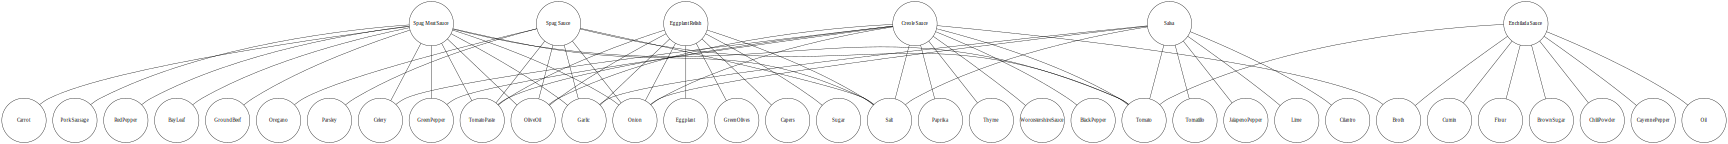

In [5]:
vz.graph2dot(
    linksDf    = df_links, 
    directed   = 0,
    graphAttrs = {'layout':'dot', 'rankdir':'TB', 'ranksep':'2', 'size':'24'},
    nodesAttrs = {'fixedsize': 'true', 'width':'1.7'},
    stdout     = False
) 

### Create the Nodes Table

In this example, the numbers of common neighbors (recipe nodes) between ingredient node pairs are of interest. The PROJECTION statement requires a nodes data table with a column that indicates which nodes are recipes and which nodes are ingredients. You can use the following statements to
generate the nodes data table (which has an identifier variable called *node* and a partition variable called *partitionFlag*).

Since we want to infer links between pairs of ingredients, we need
to assign a partition value of 1 for ingredient nodes and 0 for
recipe nodes.

In [6]:
nodes = [[node, 0] for node in df_links['from'].unique()] + [[node, 1] for node in df_links['to'].unique()]
df_nodes = pd.DataFrame(nodes, columns = ['node', 'partitionFlag'])
df_nodes.head(11)

,node,partitionFlag
0,Spag Sauce,0
1,Spag Meat Sauce,0
2,Eggplant Relish,0
3,Creole Sauce,0
4,Salsa,0
5,Enchilada Sauce,0
6,Tomato,1
7,Garlic,1
8,Salt,1
9,Onion,1


Next, upload the tables into CAS

In [7]:
s.upload(df_links, casout = {'name':'links', 'replace':True})
s.upload(df_nodes, casout = {'name':'nodes', 'replace':True});

### Run the Projection Algorithm

In [8]:
s.network.projection(
    links              = {"name": "links"},
    nodes              = {"name": "nodes"},
    outProjectionLinks = {"name": "links_out", "replace":True},
    outNeighborsList   = {"name": "neighbors_out", "replace":True},
    partition          = "partitionFlag",
    commonNeighbors    = True
    );

In [9]:
s.CASTable("links_out").head()

,from,to,commonNeighbors
0,BayLeaf,Carrot,1.0
1,BayLeaf,Celery,1.0
2,BayLeaf,Garlic,1.0
3,BayLeaf,GreenPepper,1.0
4,BayLeaf,GroundBeef,1.0


### Visualize the Result
Show projected links with at least 3 neighbors in common.

Strongly linked ingredients are likely good candidates for combination in future recipes.

For pretty visualization, it is a good idea to convert the commonNeighbors column to integer values before using it as the link weight label.

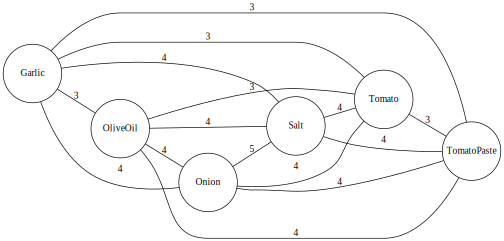

In [10]:
df_links_out = s.CASTable('links_out').to_frame()
df_links_out = df_links_out[df_links_out['commonNeighbors'] >= 3]
df_links_out['commonNeighbors'] = df_links_out['commonNeighbors'].astype(int)
vz.graph2dot(
    linksDf    = df_links_out, 
    graphAttrs = {'layout':'dot', 'size':'7'},
    nodesAttrs = {'fixedsize': 'true', 'width':'1.2'},
    linkAttrs  = {'label':'commonNeighbors'},
    stdout     = False
) 

Show recipes that contain both Garlic and OliveOil.

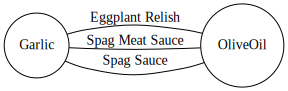

In [11]:
df_neighbors_out = s.CASTable('neighbors_out').to_frame()
df_neighbors_out = df_neighbors_out[(df_neighbors_out['from']=='Garlic') &
                                    (df_neighbors_out['to']=='OliveOil')]
vz.graph2dot(
    linksDf    = df_neighbors_out, 
    graphAttrs = {'layout':'dot', 'splines':'true'},
    linkAttrs  = {'label':'neighbor'},
    stdout     = False
) 